In [18]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time
import xarray as xr

# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES


# Q1. Does the inclusion of altitude information help the linear model perform better?

In [3]:
# Load the dataset
df_metadata = pd.read_excel(f"{BASE_DIR}/FilledDataset2012.xlsx", sheet_name="Header")
df_data_original = pd.read_csv(f"{BASE_DIR}/dataset.csv")

# make sure there is no NaN value
assert df_data_original.isnull().values.any() == False
print(f"There are {df_data_original.shape[0]} samples.")
print(
    "Each sample is associated with lat and lon coordinates.\n" + 
    "Use only the closest observation to represent each field, from 16 different NetCDF files.", )

There are 865561 samples.
Each sample is associated with lat and lon coordinates.
Use only the closest observation to represent each field, from 16 different NetCDF files.


In [4]:
df_combined = df_data_original.merge(right=df_metadata[["SKN", "ElevFT"]], left_on="skn", right_on="SKN")
df_clean = (
    df_combined.drop(
        labels=["lat", "lon", "year", "month", "SKN", "skn", "Lon_DD_updated"],
        axis=1
    ).rename(
        columns={"Lat_DD": "lat", "Lon_DD": "lon", "ElevFT": "elev"}
    )
)

In [93]:
mse_default = []
for i in range(100):
    X = np.array(df_clean.drop(labels=["data_in", "elev"], axis=1))
    Y = np.array(df_clean["data_in"])
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
    linear_regression = LinearRegression()
    linear_regression.fit(Xtrain, Ytrain)
    mse = mean_squared_error(Ytest, linear_regression.predict(Xtest))
    mse_default.append(mse)
    # print("MSE: {:.3f}".format(mean_squared_error(Ytest, linear_regression.predict(Xtest))))

In [94]:
mse_w_elev = []
for i in range(100):
    X = np.array(df_clean.drop(labels=["data_in"], axis=1))
    Y = np.array(df_clean["data_in"])
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
    linear_regression = LinearRegression()
    linear_regression.fit(Xtrain, Ytrain)
    mse = mean_squared_error(Ytest, linear_regression.predict(Xtest))
    mse_w_elev.append(mse)
    # print("MSE: {:.3f}".format(mean_squared_error(Ytest, linear_regression.predict(Xtest))))

In [95]:
np.mean(mse_default), np.mean(mse_w_elev), np.std(mse_default), np.std(mse_w_elev)

(32.628002080285775,
 32.46782561580218,
 0.37201676642057857,
 0.3547847450535934)

<BarContainer object of 2 artists>

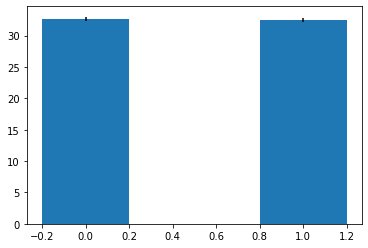

In [102]:
fig, ax = plt.subplots()
ax.bar(
    x=np.arange(2),
    height=[np.mean(mse_default), np.mean(mse_w_elev)],
    yerr=[np.std(mse_default), np.std(mse_w_elev)],
    width=0.4,
)

In [104]:
random_forest = RandomForestRegressor(n_jobs=-1, verbose=True)
random_forest.fit(Xtrain, Ytrain)
mean_squared_error(Ytest, random_forest.predict(Xtest))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.6s finished


6.3678634822428

In [106]:
xgb = XGBRegressor()
xgb.fit(Xtrain, Ytrain)
mean_squared_error(Ytest, xgb.predict(Xtest))

9.984985208025531

# Q2. How does the performance change if we smooth out the observation of reanalysis data?
We can smooth out the observation using linear interpolation. For this, 5x5 grid of observations around hawaii was used to make the resolution higher.

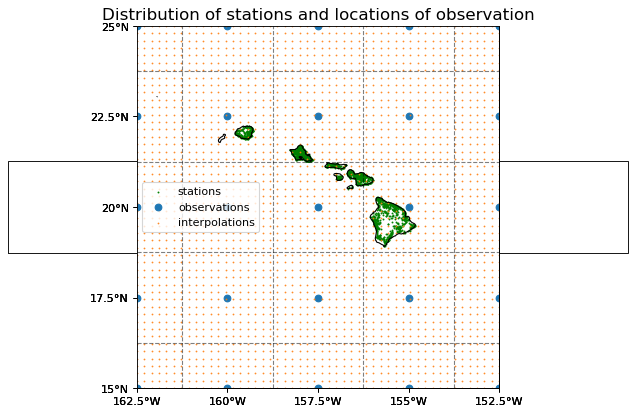

In [15]:
# load location data
df_locations = pd.read_csv(f"{BASE_DIR}/SKNlocations.csv")

lat_hawaii = [15, 17.5, 20, 22.5, 25]
lon_hawaii = [-162.5, -160, -157.5, -155, -152.5]
xx, yy = np.meshgrid(lon_hawaii, lat_hawaii)

xx_interp_50, yy_interp_50 = np.meshgrid(
    np.linspace(lon_hawaii[0], lon_hawaii[-1], 50),
    np.linspace(lat_hawaii[0], lat_hawaii[-1], 50)
)

xx_interp_100, yy_interp_100 = np.meshgrid(
    np.linspace(lon_hawaii[0], lon_hawaii[-1], 100),
    np.linspace(lat_hawaii[0], lat_hawaii[-1], 100)
)

# plt.figure(figsize=(10, 6), dpi=80)
xmin, xmax = -162.5, -152.5
ymin, ymax = 15, 25

fig, axs = plt.subplots(1, 3, figsize=(10, 6), dpi=80, subplot_kw={'projection': ccrs.PlateCarree()},)
for ax in axs:
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xticks(np.arange(xmin, xmax+1, 2.5))
    ax.set_yticks(np.arange(ymin, ymax+1, 2.5))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.grid(linewidth=2, color='black', linestyle='--')

    stations = plt.scatter(df_locations["Lon_DD"], df_locations["Lat_DD"], s=0.5, marker='o', color="green", label="stations")
    observations = plt.scatter(xx, yy, label="observations")

    interpolations = plt.scatter(xx_interp, yy_interp, label="interpolations", s=0.3)

plt.vlines(x=np.arange(xmin, xmax+1, 2.5) - 1.25, ymin=ymin, ymax=ymax, color="k", linewidth=1, linestyle="--", alpha=0.5)
plt.hlines(y=np.arange(ymin, ymax+1, 2.5) - 1.25 , xmin=xmin, xmax=xmax, color="k", linewidth=1, linestyle="--", alpha=0.5)
plt.title("Distribution of stations and locations of observation", fontsize=(15))
plt.legend()
ax.coastlines(resolution='10m')
print()

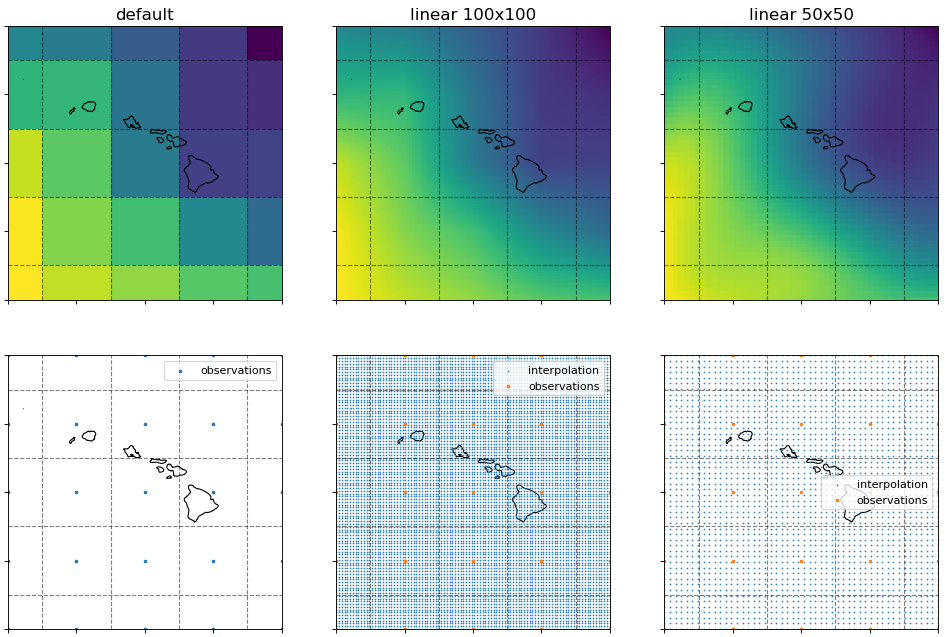

In [44]:
# load a sample dataset
ds_air2m = xr.open_dataset(f"{BASE_DIR}/air.2m.mon.mean.regridded.nc")
data_matrix = ds_air2m.loc[dict(time="1948-06-01", lon=np.array(lon_hawaii) + 360, lat=lat_hawaii)]["air"]

# apply linear interpolation
data_matrix_interp_100 = data_matrix.interp(
    lat=np.linspace(lat_hawaii[0],
                    lat_hawaii[-1],
                    100
                   ),
    lon=np.linspace(lon_hawaii[0],
                    lon_hawaii[-1],
                    100
    ) + 360,
    method="linear"
)

data_matrix_interp_50 = data_matrix.interp(
    lat=np.linspace(lat_hawaii[0],
                    lat_hawaii[-1],
                    50
                   ),
    lon=np.linspace(lon_hawaii[0],
                    lon_hawaii[-1],
                    50
    ) + 360,
    method="cubic"
)

fig, axs = plt.subplots(
    2, 3, figsize=(15, 10), dpi=80,
    subplot_kw={'projection': ccrs.PlateCarree()},
)

xmin, xmax = -162.5, -152.5
ymin, ymax = 15, 25

data_matrix.plot(ax=axs[0, 0], add_colorbar=False)
data_matrix_interp_100.plot(ax=axs[0, 1], add_colorbar=False)
data_matrix_interp_50.plot(ax=axs[0, 2], add_colorbar=False)

for ax in axs.flatten():
    ax.set_xticks(np.arange(xmin, xmax+1, 2.5))
    ax.set_yticks(np.arange(ymin, ymax+1, 2.5))
    ax.set_ylabel("")

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.coastlines(resolution='10m')
    ax.grid(linewidth=2, color='black', linestyle='--')
    ax.vlines(x=np.arange(xmin, xmax+1, 2.5) - 1.25, ymin=ymin, ymax=ymax, color="k", linewidth=1, linestyle="--", alpha=0.5)
    ax.hlines(y=np.arange(ymin, ymax+1, 2.5) - 1.25 , xmin=xmin, xmax=xmax, color="k", linewidth=1, linestyle="--", alpha=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
axs[0, 0].set_title("default", fontsize=(15))
axs[0, 1].set_title("linear 100x100", fontsize=(15))
axs[0, 2].set_title("linear 50x50", fontsize=(15))


# lower plots
lat_hawaii = [15, 17.5, 20, 22.5, 25]
lon_hawaii = [-162.5, -160, -157.5, -155, -152.5]
xx, yy = np.meshgrid(lon_hawaii, lat_hawaii)

xx_interp_50, yy_interp_50 = np.meshgrid(
    np.linspace(lon_hawaii[0], lon_hawaii[-1], 50),
    np.linspace(lat_hawaii[0], lat_hawaii[-1], 50)
)

xx_interp_100, yy_interp_100 = np.meshgrid(
    np.linspace(lon_hawaii[0], lon_hawaii[-1], 100),
    np.linspace(lat_hawaii[0], lat_hawaii[-1], 100)
)

interpolation = axs[1, 1].scatter(xx_interp_100, yy_interp_100, s=0.3, label="interpolation")
interpolation = axs[1, 2].scatter(xx_interp_50, yy_interp_50, s=0.3, label="interpolation")

for i in range(3):
    observations = axs[1, i].scatter(xx, yy, s=5, label="observations")
    axs[1, i].legend()

print()

In [6]:
df_interp_100 = pd.read_csv(f"{BASE_DIR}/dataset_interp_100.csv")

In [25]:
df_i100 = df_interp_100.drop(labels=["skn", "year", "month", "name", "Observer", "NumMos", "MinYear", "MaxYear", "Status2010"], axis=1)
Y = df_i100["data_in"]
X = df_i100.drop(["data_in"], axis=1)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
linear_regression = LinearRegression()
linear_regression.fit(Xtrain, Ytrain)
print("MSE: {:.3f}".format(mean_squared_error(Ytest, linear_regression.predict(Xtest))))


MSE: 35.768


In [26]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
random_forest = RandomForestRegressor(n_jobs=-1)
random_forest.fit(Xtrain, Ytrain)
print("MSE: {:.3f}".format(mean_squared_error(Ytest, random_forest.predict(Xtest))))

MSE: 6.642


In [ ]:
# include altitude information and compare models
# Increase the resolution, and choose the closest grid cell
# 